In [86]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from jax3dp3.viz.img import save_depth_image
from jax3dp3.utils import depth_to_coords_in_camera

from jax3dp3.shape import (
    get_rectangular_prism_shape,
    get_cube_shape,
)

import jax.numpy as jnp

In [87]:
# Initialize metadata

num_frames = 103
data_path = "data/videos"

width =  300
height =  300
fx =  150
fy =  150
cx =  150
cy =  150

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])

In [88]:
# Load and pre-process rgb and depth images

rgb_images, depth_images = [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

In [89]:
rgb_images_pil[0].save("rgb.png")
save_depth_image(depth_images[0], 30.0, "depth.png")

In [101]:
# Get masked objects based on the depth images

img_idx = 50
k = 5 if 5 <= img_idx < 19 else 4 # 4 objects in frames [5:19]

K = jnp.array([
    [fx_fy[0], 0.0, cx_cy[0]],
    [0.0, fx_fy[1], cx_cy[1]],
    [0.0, 0.0, 1.0],
])
coord_image,_ = depth_to_coords_in_camera(depth_images[img_idx], K)
print(coord_image.shape)
# -.5 < x < 1
# -.5 < y < .5
# 1.2 < z < 4
mask = np.invert(
    (coord_image[:,:,0] < 1.0) *
    (coord_image[:,:,0] > -0.5) *
    (coord_image[:,:,1] < 0.28) *
    (coord_image[:,:,1] > -0.5) *
    (coord_image[:,:,2] < 4.0) *
    (coord_image[:,:,2] > 1.2) 
)
coord_image[mask,:] = 0.0
save_depth_image(coord_image[:,:,2], 30.0, "coord_image.png")

(300, 300, 3)


In [102]:
# Do K-Means clustering to segment objects from masked depth (i.e. entity extraction)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .02)

coord_image_flat = coord_image.reshape(-1, 3).astype(dtype=np.float32)
_, labels, centers = cv2.kmeans(coord_image_flat, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

In [103]:
_a = labels.reshape(300, 300)
_img = np.stack((_a, _a, _a), axis=-1)

In [104]:
for i in range(k):
    _img[_a == i] = np.array([250, 250, 250])
    _img[_a != i] = np.array([0, 0, 0])
    PIL_image = Image.fromarray(np.uint8(_img)).convert('RGB')
    PIL_image.save(f"pil_{i}.png")


gt_images.shape (104, 300, 300, 4)


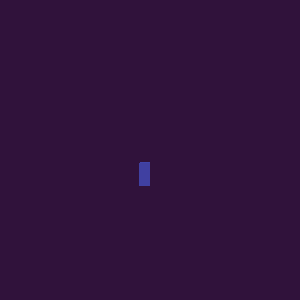

In [106]:
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.rendering import render_planes

cup_shape = get_rectangular_prism_shape([0.075, 0.15, 0.075])
reward_shape = get_cube_shape(0.08)

shape = cup_shape

gt_poses = [
    jnp.array([
    [1.0, 0.0, 0.0, -.35],   
    [0.0, 1.0, 0.0, .17],   
    [0.0, 0.0, 1.0, 2.0],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)
]
rot = R.from_euler('zyx', [0, 0, 0], degrees=True).as_matrix()
delta_pose = jnp.array([
    [1.0, 0.0, 0.0, 0.09],   
    [0.0, 1.0, 0.0, 0.05],   
    [0.0, 0.0, 1.0, 0.02],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)
delta_pose = delta_pose.at[:3,:3].set(jnp.array(rot))

for t in range(num_frames):
    gt_poses.append(gt_poses[-1].dot(delta_pose))
gt_poses = jnp.stack(gt_poses)

render_planes_jit = jax.jit(lambda p: render_planes(p, shape, height, width, fx_fy,cx_cy))
render_planes_parallel_jit = jax.jit(jax.vmap(lambda p: render_planes(p,shape,height,width,fx_fy,cx_cy)))
gt_images = render_planes_parallel_jit(gt_poses)
print("gt_images.shape", gt_images.shape)

cm = plt.get_cmap('turbo')

obsedved_image_pil = Image.fromarray(
        (cm(np.array(gt_images[i,:, :, 2]) / 30) * 255.0).astype(np.int8), mode="RGBA"
    )

obsedved_image_pil